# **Document-based English-Speaking Chatbot using Wikipedia's API**

Hello,

My name is **Anas HAMOUTNI** and I am a **Moroccan Data Scientist**.

This project is an attempt to create an **Document-based English-Speaking Chatbot** using Python's **NLTK library** and Wikipedia's content summaries through the **Wikipedia API**.

**<font color='red'>This project doesn't give a great result because Wikipedia's content is usually different than the type of content that we use for document-based chatbots, but the idea here is that this project's code can be implemented for better documents which will definitely lead to awesome results.</font>**

**[Natural Language Toolkit(NLTK)](https://www.nltk.org/)**

**NLTK** is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources, along with a suite of text processing libraries for classification, tokenization...

**[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)**

**TF-IDF** is the statistical method of evaluating the significance of a word in a given document.

**TF — Term frequency(tf)** refers to how many times a given term appears in a document.

**IDF — Inverse document frequency(idf)** measures the weight of the word in the document, i.e if the word is common or rare in the entire document.




In [202]:
#@title ##**Install necessary libraries** { display-mode: "form" }

!pip install wikipedia
!pip install gTTS
from IPython.display import clear_output
clear_output()

In [203]:
#@title ##**Import necessary libraries** { display-mode: "form" }

import nltk
import random
import string
import re, string, unicodedata
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import wikipedia as wk
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt') 
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from gtts import gTTS
from IPython.display import Audio, display
clear_output()

In [204]:
#@title ##**Selecting a Topic** { display-mode: "form" }
#@markdown **Enter Wikipedia Topic English Title**
wikipedia_title="Mathematics" #@param {type: "string"}

wk.set_lang("en") #Setting topics language
raw_data=wk.page(wikipedia_title).summary #Getting topic's wikipedia summary


# **Data Preprocessing**

Let us start with **text data cleaning** and preprocessing by converting the entire summary into a list of sentences.

Our next step is to normalize these sentences. **Normalization** is a process that **converts a list of words to a more uniform sequence**.

This step involves **Word tokenization**, **Removing ASCII values**, **Removing tags** of any kind, **Part-of-speech tagging**, and **Lemmatization**.

**Part-of-speech tagging**:

*   The automatic text annotation process in which words or tokens are assigned part of speech tags, which typically correspond to the main syntactic categories in a language (e.g., noun, verb) 

**Lemmatization**:

*    The process of grouping together the **inflected forms of a word** so they can be analysed as a **single item** (e.g., is, are, am --> be).





In [205]:
#@title ##**Sentence Tokenization** { display-mode: "form" }

raw_data.lower() #lower() method returns a string where all characters in the summary are lower case
sent_tokens = nltk.sent_tokenize(raw_data) #Converting the entire summary into a list of sentences

In [206]:
#@title ##**Normalizing the Text Data** { display-mode: "form" }

def Normalize(text):
    remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
    #word tokenization
    word_token = nltk.word_tokenize(text.lower().translate(remove_punct_dict))
    
    #remove ascii
    new_words = []
    for word in word_token:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    
    #Removing any tags
    rmv = []
    for w in new_words:
        text=re.sub("&lt;/?.*?&gt;","&lt;&gt;",w)
        rmv.append(text)
        
    #pos tagging
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    #lemmatization
    lmtzr = WordNetLemmatizer()
    lemma_list = []
    rmv = [i for i in rmv if i]
    for token, tag in nltk.pos_tag(rmv):
        lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
        lemma_list.append(lemma)
    return lemma_list

In [207]:
#@title ##**Define the Greetings function** { display-mode: "form" }

welcome_input = ("hello", "hi", "greetings", "sup", "what's up","hey",) #Expected Greetings
welcome_response = ["hi", "hey", "hi there", "hello", "I am glad! You are talking to me"] #Greetings Chatbot response

#Chatbot Welcome response function
def welcome(user_response):
    for word in user_response.split():
        if word.lower() in welcome_input:
            welcome_choice = random.choice(welcome_response) #Choosing random response from the welcome_response list
            
            return welcome_choice

# **Build Chatbot Response Function:**

**TFidf vectorizer** is used to convert the summary to a matrix of TF-IDF features and to find the similarity between words entered by the user and the words in the summary.

We will be using the **Cosine similarity** to calculate a numeric quantity that denotes the similarity between the two words.

**Cosine similarity**:

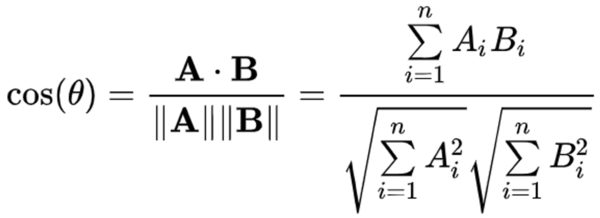

Where **A** and **B** are two vectors (sentences in our case).


**PS:** In case there is no similarity with the summary, you can **tell the chatbot to look for the answer directly in Wikipedia's website** by typing a response that contains the words: **"Search in Wikipedia for"**.

In [208]:
#@title ##**Define the Response function** { display-mode: "form" }

#The function that generates the Chatbot's response
def generateResponse(user_response):
    robo_response='' #initialize robot response
    sent_tokens.append(user_response) #add user sentence to the list of sentences of the summary
    TfidfVec = TfidfVectorizer(tokenizer=Normalize, stop_words='english') #initialize TF-IDF vectorizer
    tfidf = TfidfVec.fit_transform(sent_tokens) #fit vectorizer to the tokens of the user response
    vals = cosine_similarity(tfidf[-1], tfidf) #calculate the cosine similarity between the user response sentence (last sentence) and the different senteces of the summary
    idx=vals.argsort()[0][-2]
    flat = vals.flatten() #make a flat list out of a list of lists
    flat.sort() #sort by high similarity
    req_tfidf = flat[-2]
    if(req_tfidf==0) or "search in Wikipedia site for" in user_response: #In case there is no similarity with the summary the robot can search for the answer directly in Wikipedia website directly
        print("Checking Wikipedia")
        gTTS(text="Checking Wikipedia", lang="en", slow=False).save("audio.wav") #convert answer to audio file
        display(Audio("audio.wav", autoplay=True)) #read the audio file
        if user_response:
            robo_response = wikipedia_data(user_response) #Wikipedia answer

            gTTS(text=robo_response, lang="en", slow=False).save("audio.wav") #convert answer to audio file
            display(Audio("audio.wav", autoplay=True)) #read the audio file

            return robo_response

    else:
        robo_response = robo_response+sent_tokens[idx] #return the sentences that have the highest cosine similarity

        gTTS(text=robo_response, lang="en", slow=False).save("audio.wav") #convert answer to audio file
        display(Audio("audio.wav", autoplay=True)) #read the audio file

        return robo_response

#Wikipedia search function
def wikipedia_data(input):
    reg_ex = re.search('Search in Wikipedia for (.*)', input) #look for the words after the phrase "Search in Wikipedia for"
    try:
        if reg_ex:
            topic = reg_ex.group(1) #get the result of the search
            wiki = wk.summary(topic, sentences = 2) #Get two lines of information about the topic from Wikipedia
            return wiki
    except Exception as e:
            print("No content has been found") #If no result is found
            gTTS(text="No content has been found", lang="en", slow=False).save("audio.wav")  #convert answer to audio file
            display(Audio("audio.wav", autoplay=True))  #read the audio file


# **Some Rules**


*   If you want to greet the chatbot and get a response use one of the following words: **"hello"**, **"hi"**, **"greetings"**, **"sup"**, **"what's up"**,**"hey"**.

*   If you want to quit the chat use one the following words: **"bye"**, **"shutdown"**, **"exit"**, **"quit"**, **"thanks"**, or **"thank you"**.

*   If you want the chatbot to search for the answer in **Wikipedia**, use the following sentence format: **"Search in Wikipedia for ..."**






In [209]:
#@title ##**Run the Chatbot** { display-mode: "form" }

flag=True #Chat runs
print("My name is Anas 2.0 and I'm a chatbot. If you want to exit, type Bye!") #Welcoming message
gTTS(text="My name is Anas 2.0 and I'm a chatbot. If you want to exit, type Bye", lang="en", slow=False).save("audio.wav") #convert answer to audio file
display(Audio("audio.wav", autoplay=True)) #read the audio file

while(flag==True):
    user_response = input() #Get user's input
    user_response=user_response.lower() #Convert user's input to lower case
    if(user_response not in ['bye','shutdown','exit', 'quit']):
        if(user_response=='thanks' or user_response=='thank you' ):
            flag=False #Exit chat if user's input is "thanks" or "thank you"
            print("Anas 2.0 : You are welcome..") #last message from the Chatbot
            gTTS(text="You are welcome", lang="en", slow=False).save("audio.wav")  #convert answer to audio file
            display(Audio("audio.wav", autoplay=True)) #read the audio file
        else:
            if(welcome(user_response)!=None): 
                welome_res=welcome(user_response) #get the chatbot's greeting response
                print("Anas 2.0 : "+welome_res) #print the greeting response
                gTTS(text=welome_res, lang="en", slow=False).save("audio.wav") #convert answer to audio file
                display(Audio("audio.wav", autoplay=True)) #read the audio file
            else:
                print("Anas 2.0 : ",end="") #print the Chatbot generated data response
                print(generateResponse(user_response))
                
                sent_tokens.remove(user_response) #remove last user input from the list of tokens
    else:
        flag=False # set boolen to false if user wanna quit
        print("Anas 2.0 : Bye!!! ") #print Bye!
        gTTS(text="Bye", lang="en", slow=False).save("audio.wav") #convert answer to audio file
        display(Audio("audio.wav", autoplay=True)) #read the audio file

My name is Anas 2.0 and I'm a chatbot. If you want to exit, type Bye!


hello
Anas 2.0 : hi there


What is algebra
Anas 2.0 : 

These topics are represented in modern mathematics with the major subdisciplines of number theory, algebra, geometry, and analysis, respectively.
Search in Wikipedia for algebra 
Anas 2.0 : 

These topics are represented in modern mathematics with the major subdisciplines of number theory, algebra, geometry, and analysis, respectively.
What is Mathematics?
Anas 2.0 : 

This can be seen, for example, in the contemporary Mathematics Subject Classification, which lists more than 60 first-level areas of mathematics.
quit
Anas 2.0 : Bye!!! 
